Loading Dataset

In [16]:
import pandas as pd

df_list = []
have_label_folder = "./Park_Reviews_label"
have_label_file_name_list = os.listdir(have_label_folder)
for have_label_file_name in have_label_file_name_list:
    if not have_label_file_name.endswith(".csv"):
        continue
    have_label_file_path = os.path.join(have_label_folder, have_label_file_name)
    data_df = pd.read_csv(have_label_file_path)
    df_list.append(data_df)
data_df = pd.concat(df_list)

# df_name = "./Park_Reviews_label/singapore_botanic_gardens.csv"
# data_df = pd.read_csv(df_name)

col_name = ['review_text', 'purpose', 'time', 'family', 'children', 'crowded']

df = pd.DataFrame(data_df, columns = col_name)
train_df = df[:int(len(df)*0.8)]
test_df = df[int(len(df)*0.8):]

print(df)

                                           review_text  purpose  time  family  \
0    I didn not get to see the whole garden but it ...        1   1.0       2   
1    Singapore Botanic Garden is an awesome place f...        3   1.0       1   
2    What a park! Lots of plants are seen their. Th...        4   1.0       0   
3    If you like nature, this place is a must visit...        4   1.0       0   
4    Absolutely fantastic and we couldn't recommend...        1   1.0       1   
..                                                 ...      ...   ...     ...   
995  Another awesome place to connect with nature _...        5   1.0       0   
996  I was expecting more exotic plants, but not as...        5   1.0       0   
997  I N C R E D I B L E !!! Truly amazing botanica...        5   1.0       0   
998  It__ a Great Walk and the park is detailed wit...        5   1.0       0   
999  Wonderful park to spend a morning, an afternoo...        1   1.0       0   

     children  crowded  
0 

Build Dataset

In [17]:
from torch.utils.data import Dataset
from transformers import AutoTokenizer
class Review_Dataset(Dataset):
    def __init__(self, df, pretrain_path):
        super(Review_Dataset, self).__init__()
        self.df = df
        self.tokenizer = AutoTokenizer.from_pretrained(pretrain_path)
    def __getitem__(self, index):
        text = self.df['review_text'].iloc[index]
        encode_dict = self.tokenizer.encode_plus(text=text, max_length=512,padding='max_length', truncation=True)
        purpose_target = -100 if pd.isnull(self.df['purpose'].iloc[index]) else self.df['purpose'].iloc[index] - 1 
        time_target = -100 if pd.isnull(self.df['time'].iloc[index]) else self.df['time'].iloc[index] - 1
        family_target = -100 if pd.isnull(self.df['family'].iloc[index]) else self.df['family'].iloc[index]
        children_target = -100 if pd.isnull(self.df['children'].iloc[index]) else self.df['children'].iloc[index]
        crowded_target = -100 if pd.isnull(self.df['crowded'].iloc[index]) else self.df['crowded'].iloc[index]
        return encode_dict['input_ids'], encode_dict['token_type_ids'], encode_dict['attention_mask'], purpose_target, time_target, family_target, children_target, crowded_target
    def __len__(self):
        return len(self.df)

pretrain_path = "./bert_base_uncased"
train_dataset = Review_Dataset(train_df, pretrain_path)
test_dataset = Review_Dataset(test_df, pretrain_path)

Build DataLoader

In [18]:
from torch.utils.data import DataLoader

def get_dataloader(dataset):
    def pad_collate(batch):
        (input_ids, token_type_ids, attention_masks, purpose_target, time_target, family_target, children_target, crowded_target) = zip(*batch)
        input_ids = torch.tensor(input_ids)
        token_type_ids = torch.tensor(token_type_ids)
        attention_masks = torch.tensor(attention_masks)
        purpose_target = torch.tensor(purpose_target)
        time_target = torch.tensor(time_target)
        family_target = torch.tensor(family_target)
        children_target = torch.tensor(children_target)
        crowded_target = torch.tensor(crowded_target)
        return {"input_ids":input_ids, "token_type_ids":token_type_ids, "attention_mask":attention_masks, "purpose_target":purpose_target,"time_target":time_target,"family_target":family_target,"children_target":children_target,"crowded_target":crowded_target}
    return DataLoader(dataset, batch_size=8, shuffle=False, collate_fn=pad_collate)

train_dataloader = get_dataloader(train_dataset)
test_dataloader = get_dataloader(test_dataset)

Build Model

In [19]:
from transformers import AutoModel
import torch.nn as nn
pretrain_path = "./bert_base_uncased"

class Review_model(nn.Module):
    def __init__(self, pretrain_path):
        super(Review_model, self).__init__()
        self.bert = AutoModel.from_pretrained(pretrain_path)
        self.purpose_dense = nn.Sequential(
            nn.Linear(768, 5),
            nn.Dropout(0.1))
        self.time_dense = nn.Sequential(
            nn.Linear(768, 3),
            nn.Dropout(0.1))
        self.family_dense = nn.Sequential(
            nn.Linear(768, 3),
            nn.Dropout(0.1))
        self.children_dense = nn.Sequential(
            nn.Linear(768, 3),
            nn.Dropout(0.1))
        self.crowded_dense = nn.Sequential(
            nn.Linear(768, 3),
            nn.Dropout(0.1))
    def forward(self,batch_data):
        out_put = self.bert(input_ids=batch_data["input_ids"],
                            token_type_ids=batch_data["token_type_ids"],
                            attention_mask=batch_data["attention_mask"])
        purpose_predict = self.purpose_dense(out_put["pooler_output"])
        time_predict = self.time_dense(out_put["pooler_output"])
        family_predict = self.family_dense(out_put["pooler_output"])
        children_predict = self.children_dense(out_put["pooler_output"])
        crowded_predict = self.crowded_dense(out_put["pooler_output"])
        return purpose_predict, time_predict, family_predict, children_predict, crowded_predict

review_model = Review_model(pretrain_path)

Some weights of the model checkpoint at ./bert_base_uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Train

In [20]:
import torch
from tqdm import tqdm
epoch = 5
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
review_model.to(device)
optim = torch.optim.AdamW(review_model.parameters(), lr=2e-5, weight_decay=1e-4)  # AdamW优化器
purpose_loss = nn.CrossEntropyLoss()
time_loss = nn.CrossEntropyLoss()
family_loss = nn.CrossEntropyLoss()
children_loss = nn.CrossEntropyLoss()
crowded_loss = nn.CrossEntropyLoss()
review_model.train()
print("Start training...")
for e in range(epoch):
    with tqdm(total=len(train_dataloader)) as _tqdm:
        _tqdm.set_description('epoch: {}/{}'.format(e + 1, epoch))
        for index, batch in enumerate(train_dataloader):

            batch = {k: v.to(device) for k, v in batch.items()}
            purpose_predict, time_predict, family_predict, children_predict, crowded_predict = review_model(batch)
            purpose_label, time_label, family_label, children_label, crowded_label = batch["purpose_target"].long(), batch["time_target"].long(), batch["family_target"].long(), batch["children_target"].long(), batch["crowded_target"].long()
            p_loss = purpose_loss(purpose_predict, purpose_label)
            t_loss = time_loss(time_predict, time_label)
            f_loss = family_loss(family_predict, family_label)
            c_loss = children_loss(children_predict, children_label)
            cd_loss = crowded_loss(crowded_predict,  crowded_label)
            loss = p_loss + t_loss + f_loss + c_loss + cd_loss
            _tqdm.set_postfix(loss='{:.3f}'.format(loss.data))
            _tqdm.update(1)
            loss.backward()
            optim.step()
            optim.zero_grad()
print("Finish training！")

Start training...


epoch: 5/5: 100%|██████████| 100/100 [00:20<00:00,  4.78it/s, loss=1.569]

Finish training！


Test

In [21]:
from sklearn.metrics import accuracy_score

review_model.eval()
purpose_predicts, purpose_labels = [], []
time_predicts, time_labels = [], []
family_predicts, family_labels = [], []
children_predicts, children_labels = [], []
crowded_predicts, crowded_labels = [], []
print("Start testing！")
with torch.no_grad():
    with tqdm(total=len(test_dataloader)) as _tqdm:
        for index, batch in tqdm(enumerate(test_dataloader)):
            batch = {k: v.to(device) for k, v in batch.items()}
            purpose_pro, time_pro, family_pro, children_pro, crowded_pro = review_model(batch)
            purpose_predict, time_predict, family_predict, children_predict, crowded_predict = torch.argmax(purpose_pro, dim=1), torch.argmax(time_pro, dim=1), torch.argmax(family_pro, dim=1), torch.argmax(children_pro, dim=1), torch.argmax(crowded_pro, dim=1)
            purpose_label, time_label, family_label, children_label, crowded_label = batch["purpose_target"].long(), batch["time_target"].long(), batch["family_target"].long(), batch["children_target"].long(), batch["crowded_target"].long()
            _tqdm.update(1)
            purpose_predicts.extend(purpose_predict.cpu().numpy().tolist())
            purpose_labels.extend(purpose_label.cpu().numpy().tolist())
            time_predicts.extend(time_predict.cpu().numpy().tolist())
            time_labels.extend(time_label.cpu().numpy().tolist())
            family_predicts.extend(family_predict.cpu().numpy().tolist())
            family_labels.extend(family_label.cpu().numpy().tolist())
            children_predicts.extend(children_predict.cpu().numpy().tolist())
            children_labels.extend(children_label.cpu().numpy().tolist())
            crowded_predicts.extend(crowded_predict.cpu().numpy().tolist())
            crowded_labels.extend(crowded_label.cpu().numpy().tolist())
print("ACC on purpose:", accuracy_score(purpose_labels, purpose_predicts))
print("ACC on time:", accuracy_score(time_labels, time_predicts))
print("ACC on family:", accuracy_score(family_labels, family_predicts))
print("ACC on children:", accuracy_score(children_labels, children_predicts))
print("ACC on crowded:", accuracy_score(crowded_labels, crowded_predicts))

Start testing！


 96%|█████████▌| 24/25 [00:01<00:00, 16.43it/s]
25it [00:01, 16.41it/s]
100%|██████████| 25/25 [00:01<00:00, 16.39it/s]

ACC on purpose: 0.615
ACC on time: 0.99
ACC on family: 0.96
ACC on children: 0.945
ACC on crowded: 0.97


Prediction

In [22]:
import os
class Review_predict_Dataset(Dataset):
    def __init__(self, df, pretrain_path):
        super(Review_predict_Dataset, self).__init__()
        self.df = df
        self.tokenizer = AutoTokenizer.from_pretrained(pretrain_path)
    def __getitem__(self, index):
        text = self.df['review_text'].iloc[index]
        encode_dict = self.tokenizer.encode_plus(text=text, max_length=512,padding='max_length', truncation=True)
        return encode_dict['input_ids'], encode_dict['token_type_ids'], encode_dict['attention_mask']
    def __len__(self):
        return len(self.df)
    
def get_dataloader_test(dataset):
    def pad_collate(batch):
        (input_ids, token_type_ids, attention_masks) = zip(*batch)
        input_ids = torch.tensor(input_ids)
        token_type_ids = torch.tensor(token_type_ids)
        attention_masks = torch.tensor(attention_masks)
        return {"input_ids":input_ids, "token_type_ids":token_type_ids, "attention_mask":attention_masks}
    return DataLoader(dataset, batch_size=8, shuffle=False, collate_fn=pad_collate)

need_to_predict_folder = "./Park_Reviews_no_label"
predict_folder = "./Park_Reviews_Prediction"
need_to_predict_file_list = os.listdir(need_to_predict_folder)
for file_name in need_to_predict_file_list:
    file_path = os.path.join(need_to_predict_folder, file_name)
    test_df = pd.read_csv(file_path)
    test_dataset = Review_predict_Dataset(test_df, pretrain_path)
    test_dataloader = get_dataloader_test(test_dataset)
    review_model.eval()
    purpose_predicts= []
    time_predicts=[]
    family_predicts= []
    children_predicts= []
    crowded_predicts= []
    with torch.no_grad():
        with tqdm(total=len(test_dataloader)) as _tqdm:
            for index, batch in tqdm(enumerate(test_dataloader)):
                batch = {k: v.to(device) for k, v in batch.items()}
                purpose_pro, time_pro, family_pro, children_pro, crowded_pro = review_model(batch)
                purpose_predict, time_predict, family_predict, children_predict, crowded_predict = torch.argmax(purpose_pro, dim=1), torch.argmax(time_pro, dim=1), torch.argmax(family_pro, dim=1), torch.argmax(children_pro, dim=1), torch.argmax(crowded_pro, dim=1)
                _tqdm.update(1)
                purpose_predict += 1
                time_predict += 1 
                purpose_predicts.extend(purpose_predict.cpu().numpy().tolist())
                time_predicts.extend(time_predict.cpu().numpy().tolist())
                family_predicts.extend(family_predict.cpu().numpy().tolist())
                children_predicts.extend(children_predict.cpu().numpy().tolist())
                crowded_predicts.extend(crowded_predict.cpu().numpy().tolist())
    test_df['purpose'] = purpose_predicts
    test_df['time'] = time_predicts
    test_df['family'] = family_predicts
    test_df['children'] = children_predicts
    test_df['crowded'] = crowded_predicts
    save_path = os.path.join(predict_folder, file_name)
    test_df.to_csv(save_path)
print("Prediction Finish!")

            
    

 99%|█████████▉| 124/125 [00:07<00:00, 16.84it/s]
125it [00:07, 16.75it/s]
 99%|█████████▉| 124/125 [00:07<00:00, 16.85it/s]
125it [00:07, 16.88it/s]
 98%|█████████▊| 42/43 [00:02<00:00, 16.88it/s]
43it [00:02, 16.89it/s]
 99%|█████████▉| 94/95 [00:05<00:00, 16.79it/s]
95it [00:05, 16.90it/s]
100%|██████████| 98/98 [00:05<00:00, 17.30it/s]
98it [00:05, 16.80it/s]
 99%|█████████▉| 124/125 [00:07<00:00, 16.86it/s]
125it [00:07, 16.74it/s]
 99%|█████████▉| 124/125 [00:07<00:00, 16.93it/s]
125it [00:07, 16.75it/s]
 98%|█████████▊| 82/84 [00:04<00:00, 16.53it/s]
84it [00:05, 16.77it/s]
 98%|█████████▊| 56/57 [00:03<00:00, 16.63it/s]
57it [00:03, 16.67it/s]
100%|██████████| 62/62 [00:03<00:00, 16.84it/s]
62it [00:03, 16.72it/s]
 99%|█████████▉| 124/125 [00:07<00:00, 16.76it/s]
125it [00:07, 16.66it/s]
 99%|█████████▉| 124/125 [00:07<00:00, 16.79it/s]
125it [00:07, 16.71it/s]
 95%|█████████▍| 36/38 [00:02<00:00, 16.55it/s]
38it [00:02, 16.76it/s]
 99%|█████████▉| 124/125 [00:07<00:00, 16.64it

Prediction Finish!


Recommand Dataset Load

In [3]:
import os
import pandas as pd

In [4]:
garden2index = {}
index2garden = {}

index = 0
df_list = []
label_file_folder = "./Park_Reviews_label"
label_file_name_list = os.listdir(label_file_folder)
for label_file_name in label_file_name_list:
    if not label_file_name.endswith(".csv"):
        continue
    label_file_path = os.path.join(label_file_folder, label_file_name)
    label_file_df = pd.read_csv(label_file_path)
    park_name = "_".join(label_file_name[:-4].split(" "))
    garden2index[park_name] = index
    index2garden[index + 1] = park_name
    label_file_df["label"] = index
    df_list.append(label_file_df)
    index += 1

predict_file_folder = "./Park_Reviews_Prediction"
predict_file_name_list = os.listdir(predict_file_folder)

for predict_file_name in predict_file_name_list:
    if not predict_file_name.endswith(".csv"):
        continue
    predict_file_path = os.path.join(predict_file_folder, predict_file_name)
    predict_file_df = pd.read_csv(predict_file_path)
    park_name = "_".join(predict_file_name[:-4].split(" "))
    garden2index[park_name] = index
    index2garden[index + 1] = park_name
    predict_file_df["label"] = index
    df_list.append(predict_file_df)
    index += 1
    
df = pd.concat(df_list)

df_train = df[:int(len(df)*0.8)]
df_test = df[int(len(df)*0.8):]

all_columns = ['purpose', 'time', 'family', 'children', 'crowded', 'label']
df_train_datset = pd.DataFrame(df_train, columns=all_columns)
df_test_datset = pd.DataFrame(df_test, columns=all_columns)

df_train = df_train_datset.dropna()
df_test = df_test_datset.dropna()

x_columns = ['purpose', 'time', 'family', 'children', 'crowded']
df_train_x = pd.DataFrame(df_train, columns=x_columns)
df_test_x = pd.DataFrame(df_test, columns=x_columns)
y_columns = ['label']
df_train_y = pd.DataFrame(df_train, columns=y_columns)
df_test_y = pd.DataFrame(df_test, columns=y_columns)


In [5]:
from sklearn import svm
from sklearn.metrics import accuracy_score
svc = svm.SVC(kernel = 'linear')
svc.fit(df_train_x, df_train_y)
test_prediction = svc.predict(df_test_x)

print("ACC on recommand:", accuracy_score(df_test_y.label.tolist(), test_prediction))


c:\Users\33321\anaconda3\envs\pytorch\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ACC on recommand: 0.0


park score matching

In [1]:
import os
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
df_list = []

label_file_folder = "./Park_Reviews_label"
label_file_name_list = os.listdir(label_file_folder)
for label_file_name in label_file_name_list:
    if not label_file_name.endswith(".csv"):
        continue
    label_file_path = os.path.join(label_file_folder, label_file_name)
    label_file_df = pd.read_csv(label_file_path)
    park_name = "_".join(label_file_name[:-4].split(" "))
    label_file_df["park_name"] = park_name
    df_list.append(label_file_df)


predict_file_folder = "./Park_Reviews_Prediction"
predict_file_name_list = os.listdir(predict_file_folder)

for predict_file_name in predict_file_name_list:
    if not predict_file_name.endswith(".csv"):
        continue
    predict_file_path = os.path.join(predict_file_folder, predict_file_name)
    predict_file_df = pd.read_csv(predict_file_path)
    park_name = "_".join(predict_file_name[:-4].split(" "))
    predict_file_df["park_name"] = park_name
    df_list.append(predict_file_df)

    
df = pd.concat(df_list)

all_columns = ['purpose', 'time', 'family', 'children', 'crowded', 'park_name',"rating"]

df = df[all_columns]

In [3]:
purpose_map = {1:"leisure", 2:"social", 3:"exercise", 4:"photography", 5:"other"}

time_map = {1:"morning", 2:"afternoon", 3:"evening"}

faimly_map = {0:"None",1:"yes", 2:"no"}

children_map = {0:"None",1:"yes", 2:"no"}

crowded_map = {0:"None",1:"yes", 2:"no"}

In [4]:
df["purpose"] = df["purpose"].map(purpose_map)
df["time"] = df["time"].map(time_map)
df["family"] = df["family"].map(faimly_map)
df["children"] = df["children"].map(children_map)
df["crowded"] = df["crowded"].map(crowded_map)

In [5]:
expand_df= pd.get_dummies(df, columns=["purpose", "time", "family", "children", "crowded"])
park_score = expand_df.groupby("park_name").mean()

In [6]:
# standardize the score minmax
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
park_score_standardize = min_max_scaler.fit_transform(park_score)
park_score_standardize = pd.DataFrame(park_score_standardize, columns=park_score.columns, index=park_score.index)
park_score_standardize

,rating,purpose_exercise,purpose_leisure,purpose_other,purpose_photography,purpose_social,time_afternoon,time_evening,time_morning,family_None,family_no,family_yes,children_None,children_no,children_yes,crowded_None,crowded_no,crowded_yes
park_name,,,,,,,,,,,,,,,,,,
admiralty_park,0.714286,0.000000,0.455722,0.841418,0.010509,0.881579,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0000,1.000000,1.000000,0.000000,0.000000
bukit_batok_nature_park,0.714286,0.709639,0.124334,0.656716,0.582809,0.184211,0.000000,0.000000,1.000000,0.932331,0.000000,0.067669,0.937810,0.0000,0.062190,1.000000,0.000000,0.000000
bukit_timah_nature_reserve,0.714286,0.760328,1.000000,0.000000,0.128178,0.000000,0.281196,0.308793,0.708133,0.919799,0.663333,0.075188,0.896245,0.4975,0.101157,0.158866,0.031094,1.000000
changi_beach_park,0.714286,0.168962,0.475806,0.587687,0.395608,0.934211,0.000000,0.000000,1.000000,0.704261,0.000000,0.295739,0.805322,0.0000,0.194678,1.000000,0.000000,0.000000
chinese_garden,0.571429,0.290614,0.216721,0.751866,0.679084,0.302632,0.000000,0.000000,1.000000,0.899749,0.000000,0.100251,0.901441,0.0000,0.098559,1.000000,0.000000,0.000000
dairy_farm_nature_park,0.714286,0.608974,0.002420,0.940888,0.279065,0.117959,0.000000,0.000000,1.000000,0.973179,0.000000,0.026821,0.958775,0.0000,0.041225,1.000000,0.000000,0.000000
east_coast_park,0.857143,0.733294,0.389444,0.397388,0.251196,1.000000,0.000000,0.000000,1.000000,0.538847,0.000000,0.461153,0.709203,0.0000,0.290797,1.000000,0.000000,0.000000
hindhede_nature_park,0.714286,0.315020,0.124276,0.886336,0.572300,0.127578,0.000000,0.000000,1.000000,0.940201,0.000000,0.059799,0.939785,0.0000,0.060215,1.000000,0.000000,0.000000
japanese_garden,0.571429,0.239926,0.154460,0.854478,0.693347,0.149123,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.989766,0.0000,0.010234,1.000000,0.000000,0.000000


In [7]:
weight = [0.4, 0.3, 0.15, 0.1, 0.05]

In [13]:
# personal preference：leisure > afternoon > family > children > no crowded

preference_map={"purpose_leisure":0,"time_afternoon":1,"family_yes":2,"children_yes":3,"crowded_no":4}

recommendation_result = pd.DataFrame({"park_name":park_score_standardize.index, "score":0})
for key in preference_map:
    recommendation_result["score"]  = (park_score_standardize[key] * weight[preference_map[key]]).values + recommendation_result["score"].values


print("Assume the preference is: leisure > afternoon > family > children > no crowded")
print("Recommendation Result:")
recommendation_result.sort_values(by="score", ascending=False)

Assume the preference is: leisure > afternoon > family > children > no crowded
Recommendation Result:


,park_name,score
21,west_coast_park(1),0.623198
2,bukit_timah_nature_reserve,0.507307
0,admiralty_park,0.432289
15,sembawang_park,0.277135
3,changi_beach_park,0.254151
6,east_coast_park,0.254030
13,pasir_ris_park,0.232805
11,lower_seletar_reservoir_park,0.202875
17,singapore_botanic_gardens,0.200063
20,upper_peirce_reservoir_park,0.169539


In [14]:
# personal preference：Children》family》leisure》afternoon》no crowded

preference_map={"purpose_leisure":2,"time_afternoon":3,"family_yes":1,"children_yes":0,"crowded_no":4}

recommendation_result = pd.DataFrame({"park_name":park_score_standardize.index, "score":0})
for key in preference_map:
    recommendation_result["score"]  = (park_score_standardize[key] * weight[preference_map[key]]).values + recommendation_result["score"].values

print("Assume the preference is: Children > family > leisure > afternoon > no crowded")
print("Recommendation Result:")
recommendation_result.sort_values(by="score", ascending=False)

Assume the preference is: Children > family > leisure > afternoon > no crowded
Recommendation Result:


,park_name,score
0,admiralty_park,0.768358
21,west_coast_park(1),0.621372
15,sembawang_park,0.316450
6,east_coast_park,0.313081
13,pasir_ris_park,0.288881
2,bukit_timah_nature_reserve,0.242694
3,changi_beach_park,0.237964
17,singapore_botanic_gardens,0.221217
11,lower_seletar_reservoir_park,0.175388
18,sungei_buloh_wetland_reserve,0.107771


Word cloud


In [65]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string
import re
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\33321\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\33321\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\33321\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\33321\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\33321\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


True

In [61]:
comments = pd.concat(df_list)["review_text"].dropna().tolist()

In [69]:
# Clean the comments
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)
regex = re.compile('[^a-zA-Z]')  # Regex to remove non-alphabetic characters

cleaned_comments = []
for comment in comments:
    # Remove non-alphabetic characters
    comment = regex.sub(' ', comment)
    
    # Tokenize the comment
    tokens = nltk.word_tokenize(comment.lower())
    
    # Remove stop words and punctuations
    filtered_tokens = [token for token in tokens if token not in stop_words and token not in punctuations]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Remove short words
    long_tokens = [token for token in lemmatized_tokens if len(token) > 2]
    
    # Join the tokens to form a string
    cleaned_comment = " ".join(long_tokens)
    cleaned_comments.append(cleaned_comment)
    
# Combine the cleaned comments into a single string
cleaned_text = " ".join(cleaned_comments)

<Figure size 800x800 with 0 Axes>

(-0.5, 799.5, 799.5, -0.5)

Text(0.5, 1.0, 'Word Cloud of Park Reviews')

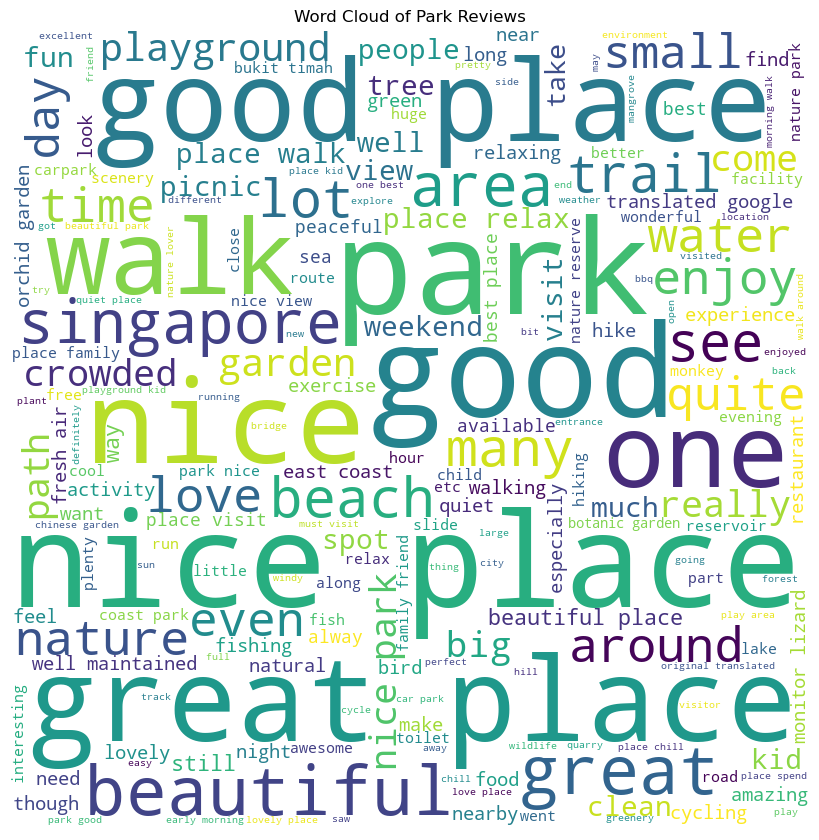

In [70]:
# Combine the cleaned comments into a single string
cleaned_text = " ".join(cleaned_comments)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10,repeat=False).generate(cleaned_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Word Cloud of Park Reviews")
plt.show()


In [74]:
# Clean the comments
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)
regex = re.compile('[^a-zA-Z]')  # Regex to remove non-alphabetic characters

cleaned_comments = []
for comment in comments:
    # Remove non-alphabetic characters
    comment = regex.sub(' ', comment)
    
    # Tokenize the comment
    tokens = nltk.word_tokenize(comment.lower())
    
    # Remove stop words and punctuations
    filtered_tokens = [token for token in tokens if token not in stop_words and token not in punctuations]
    
    # Lemmatize the tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    tagged_words = nltk.pos_tag(lemmatized_tokens)
    non_adj_words = [word for word, pos in tagged_words if pos != 'JJ']
    
    # Remove short words
    long_tokens = [token for token in non_adj_words if len(token) > 2]
    
    # Join the tokens to form a string
    cleaned_comment = " ".join(long_tokens)
    cleaned_comments.append(cleaned_comment)
    
# Combine the cleaned comments into a single string
cleaned_text = " ".join(cleaned_comments)

<Figure size 800x800 with 0 Axes>

(-0.5, 799.5, 799.5, -0.5)

Text(0.5, 1.0, 'Word Cloud of Park Reviews: Remove Adjectives')

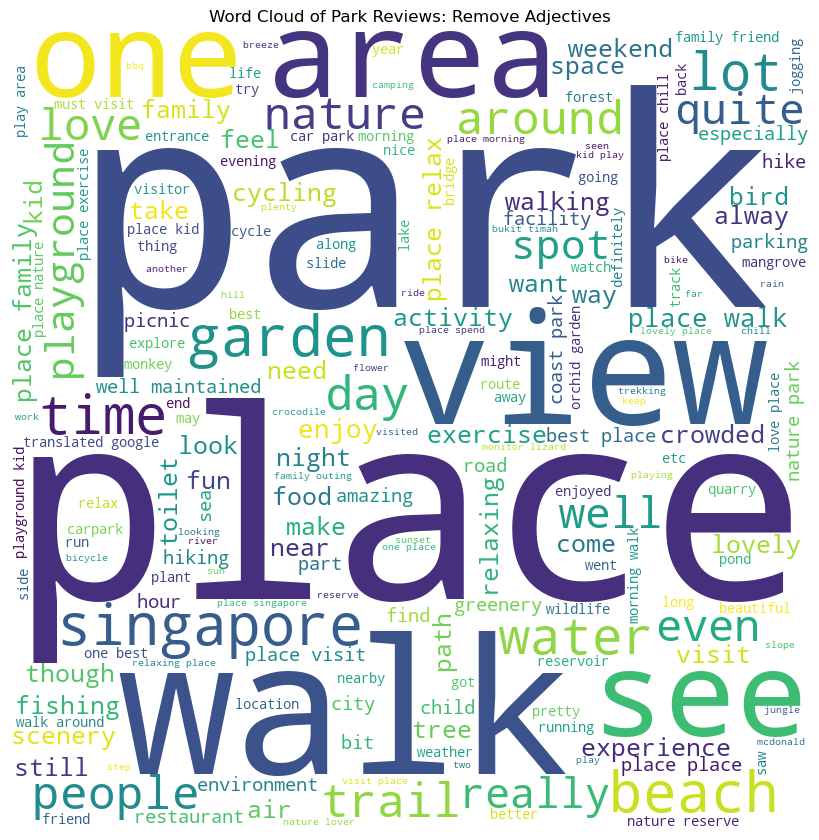

In [75]:
# Combine the cleaned comments into a single string
cleaned_text = " ".join(cleaned_comments)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10,repeat=False).generate(cleaned_text)

plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.title("Word Cloud of Park Reviews: Remove Adjectives")
plt.show()
